In [1]:
import qcodes as qc
from qcodes import Parameter
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import load_by_id
from qcodes.instrument_drivers.NI.PXI_6251 import PXI_6251

import nidaqmx
from matplotlib import pyplot as plt
import numpy as np

import time

from lmfit import Model

In [2]:
%matplotlib notebook

In [3]:
daq = PXI_6251("daq")

In [4]:
station = qc.Station(daq)
qc.new_experiment(name='test_PXI_DAQ', sample_name='fiber181')

test_PXI_DAQ#fiber181#42@C:\Users\He5user/experiments.db
--------------------------------------------------------

In [5]:
sampling_rate_Hz = 333333
sampling_time_s = 2.5
N_samps = int(sampling_rate_Hz*sampling_time_s)

# with retriggerable counter

In [7]:
daq.add_task("ai_task")

daq.ai_task.add_ai_volt_channel('PDt','PXI-6251/ai0',
        terminal_config=nidaqmx.constants.TerminalConfiguration.RSE,
        min_val=-.1,
        max_val=1)
daq.ai_task.add_ai_volt_channel('PDr','PXI-6251/ai1',
        terminal_config=nidaqmx.constants.TerminalConfiguration.RSE,
        min_val=-.1,
        max_val=1)
daq.ai_task.add_ai_volt_channel('AWG','PXI-6251/ai2',
        terminal_config=nidaqmx.constants.TerminalConfiguration.RSE,
        min_val=-.1,
        max_val=2.1)

daq.ai_task.add_sample_clock(sampling_rate_Hz,
                             source='/PXI-6251/Ctr0InternalOutput',
                             sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS,
                             samps_per_chan=N_samps+1000)

daq.add_task("co_task")

daq.co_task.add_co_freq_channel('co', 'PXI-6251/ctr0', freq=sampling_rate_Hz)

daq.co_task.add_implicit_clock(sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
                               samps_per_chan=N_samps)

daq.co_task.start_trigger.trig_type.set(nidaqmx.constants.TriggerType.DIGITAL_EDGE)
daq.co_task.start_trigger.dig_edge_src.set('/PXI-6251/PFI0')
daq.co_task.start_trigger.retriggerable.set(True)

In [8]:
meas = Measurement()

In [9]:
daq.ai_task.AIRead.prepare_AIRead(setpointlist = tuple(np.linspace(0, (N_samps-1)/sampling_rate_Hz, N_samps)))

In [10]:
seq_num = Parameter(name='seq_num', label='seq_num', unit='',
                    set_cmd=None, get_cmd=None)
meas.register_parameter(seq_num)

In [11]:
meas.register_parameter(daq.ai_task.AIRead, paramtype='array', setpoints=(seq_num,))

In [12]:
daq.ai_task.start()
daq.co_task.start()

In [13]:
with meas.run() as datasaver:
    for i in range(5):
        # trigger
        
        while daq.ai_task._task.in_stream.avail_samp_per_chan < N_samps:
            time.sleep(0.1)
            
        print(f"co count: {daq.co_task.co.co_count.get()}")
        print(f"samples: {daq.ai_task._task.in_stream.avail_samp_per_chan}")            
        print(f"co finished ?: {daq.co_task.co.co_pulse_done.get()}")
        
        traces = daq.ai_task.AIRead.get()
        print(f"samples read: {len(traces[0])}")

        datasaver.add_result((seq_num, i),
                             (daq.ai_task.AIRead, traces))
        
        print(i)
    
    run_id = datasaver.run_id

Starting experimental run with id: 63
co count: 1
samples: 833332
co finished ?: True
samples read: 833332
0
co count: 1
samples: 833332
co finished ?: True
samples read: 833332
1
co count: 1
samples: 833332
co finished ?: True
samples read: 833332
2
co count: 1
samples: 833332
co finished ?: True
samples read: 833332
3
co count: 1
samples: 833332
co finished ?: True
samples read: 833332
4


In [14]:
daq.ai_task.stop()
daq.co_task.stop()

C:\Users\He5user\Anaconda3\envs\qcodes\lib\site-packages\nidaqmx\errors.py:141: DaqWarning: 
Warning 200010 occurred.

Finite acquisition or generation has been stopped before the requested number of samples were acquired or generated.
  error_buffer.value.decode("utf-8"), error_code))


# with start/stop task

In [6]:
daq.add_task("task")

daq.task.add_ai_channel('PDr','PXI-6251/ai0',
        terminal_config=nidaqmx.constants.TerminalConfiguration.RSE,
        min_val=-.1,
        max_val=1)
daq.task.add_ai_channel('PDt','PXI-6251/ai1',
        terminal_config=nidaqmx.constants.TerminalConfiguration.RSE,
        min_val=-.1,
        max_val=1)
daq.task.add_ai_channel('AWG','PXI-6251/ai2',
        terminal_config=nidaqmx.constants.TerminalConfiguration.RSE,
        min_val=-.1,
        max_val=2.1)

daq.task.add_sample_clock(333333, source='/PXI-6251/ai/SampleClockTimebase',
                            sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
                            samps_per_chan=int(sampling_rate_Hz*sampling_time_s))

daq.task.start_trigger.trig_type.set(nidaqmx.constants.TriggerType.DIGITAL_EDGE)
daq.task.start_trigger.dig_edge_src.set('/PXI-6251/PFI0')

In [28]:
i=0
task_ready = False
daq.task.start()
while not task_ready:
    try:
        daq.task._task.control(nidaqmx.constants.TaskMode.TASK_VERIFY)
        print(i)
    except nidaqmx.errors.DaqError as e:
        if e.error_type is nidaqmx.error_codes.DAQmxErrors.CAN_NOT_PERFORM_OP_WHILE_TASK_RUNNING:
            task_ready = True
        else:
            raise e
    i+=1
    time.sleep(.01)

In [7]:
meas = Measurement()

In [8]:
daq.task.AIRead.prepare_AIRead()

In [10]:
seq_num = Parameter(name='seq_num', label='seq_num', unit='',
                    set_cmd=None, get_cmd=None)
meas.register_parameter(seq_num)

In [12]:
meas.register_parameter(daq.task.AIRead, paramtype='array', setpoints=(seq_num,))

In [13]:
with meas.run() as datasaver:
    for i in range(5):
        daq.task.start()

        while not daq.task._task.is_task_done():
            time.sleep(0.1)

        datasaver.add_result((seq_num, i),
                             (daq.task.AIRead, daq.task.AIRead.get()))

        daq.task.stop()
        
        print(i)
    
    run_id = datasaver.run_id

Starting experimental run with id: 58
0
1
2
3
4


In [15]:
meas.parameters

OrderedDict([('seq_num',
              ParamSpec('seq_num', 'numeric', 'seq_num', '', inferred_from=[], depends_on=[])),
             ('Time',
              ParamSpec('Time', 'array', 'Time', 's', inferred_from=[], depends_on=[])),
             ('PDr',
              ParamSpec('PDr', 'array', 'PDr', 'V', inferred_from=[], depends_on=['seq_num', 'Time'])),
             ('PDt',
              ParamSpec('PDt', 'array', 'PDt', 'V', inferred_from=[], depends_on=['seq_num', 'Time'])),
             ('AWG',
              ParamSpec('AWG', 'array', 'AWG', 'V', inferred_from=[], depends_on=['seq_num', 'Time']))])

# plotting

In [15]:
ds = load_by_id(run_id)

<IPython.core.display.Javascript object>


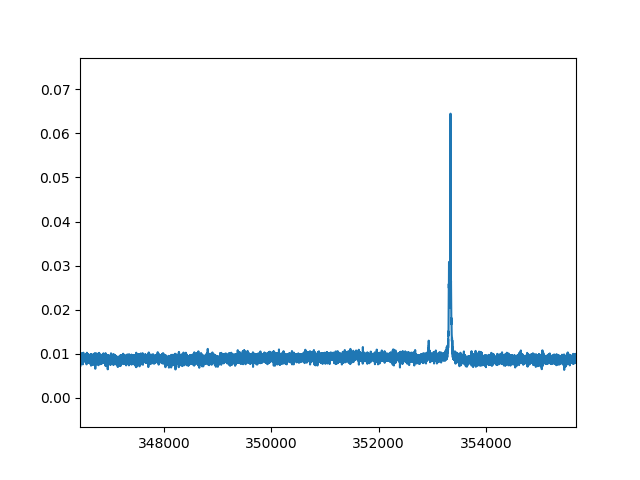

In [16]:
fig, ax = plt.subplots()
ax.plot(ds.get_parameter_data('PDt')['PDt']['PDt'][0])

In [17]:
x,y,z = [ds.get_parameter_data('PDr')['PDr'][key] for key in ['seq_num', 'Time', 'PDr']]

<IPython.core.display.Javascript object>


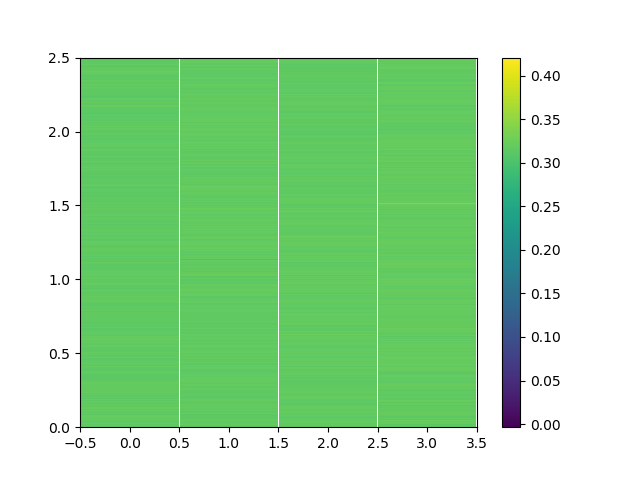

In [18]:
fig, ax = plt.subplots()
mesh = ax.pcolormesh(x-0.5, y, z, rasterized=True)
#ax.axis([X.min(), X.max(), Y.min(), Y.max()])
cax = plt.colorbar(mesh, ax=ax);

<IPython.core.display.Javascript object>


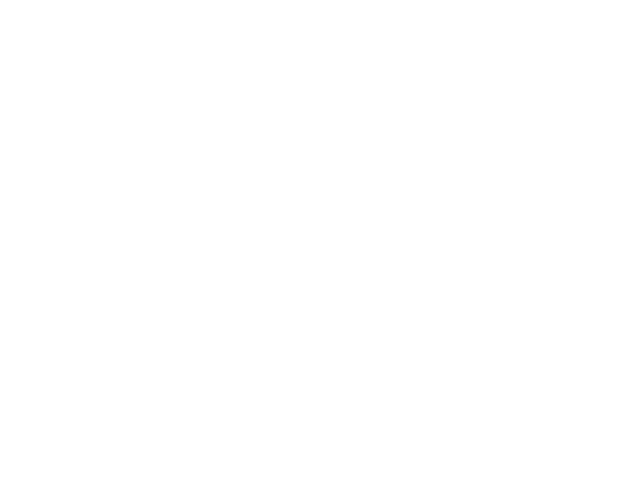

<IPython.core.display.Javascript object>


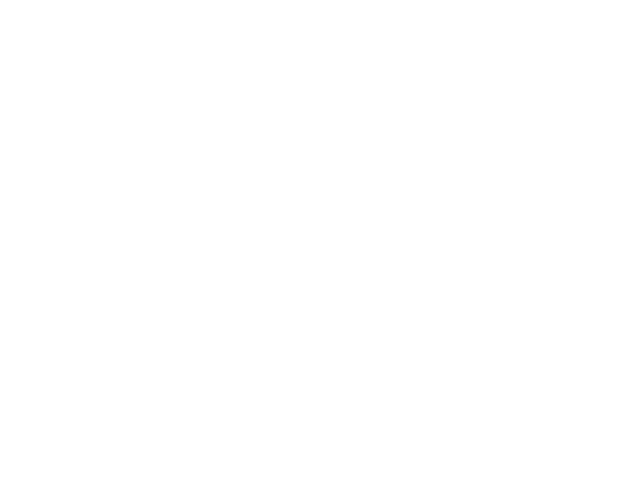

<IPython.core.display.Javascript object>


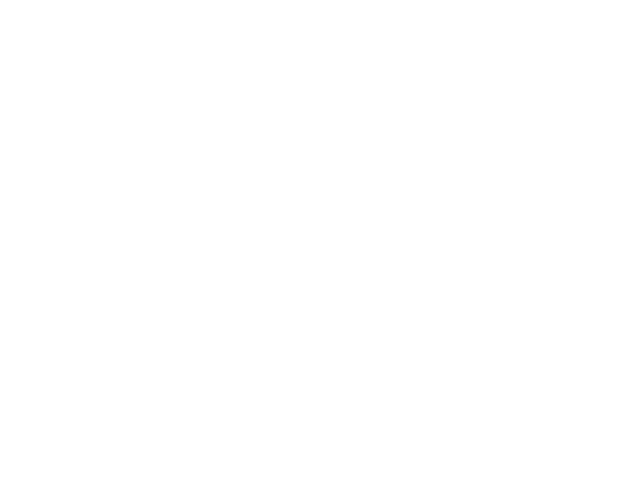

KeyboardInterrupt: 

In [14]:
plot_by_id(datasaver.run_id)

In [19]:
daq.close()

{'freq': 0.1999733837228002, 'amp': 1.9840034689145216, 'offset': 0.9952329540493983, 't0': 1.2498094990988526}


<IPython.core.display.Javascript object>


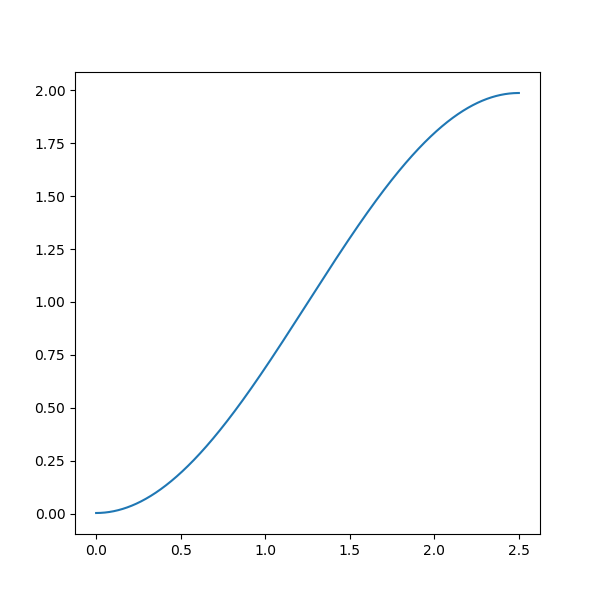

In [12]:
def sine(t, freq, amp, offset, t0):
    return offset + amp/2*np.sin((t-t0)*freq*2*np.pi)
gmodel = Model(sine)
result = gmodel.fit(c3, t=t, freq=0.2, amp=2, offset=1, t0=1.25)

print(result.best_values)

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(result.best_fit, c3)
ax.plot(result.best_fit, c1)
ax.plot(result.best_fit, c2)